In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


경로 설정

In [1]:
import os
os.chdir('/content/drive/MyDrive/Visual-Odometry')

# Visual Odometry for Localization in Autonomous Driving

Visual Features - Detection, Description and Matching. In this assignment, you will practice using the material you have learned to estimate an autonomous vehicle trajectory by images taken with a monocular camera set up on the vehicle.


**In this assignment, you will:**
- Extract  features from the photographs  taken with a camera setup on the vehicle.
- Use the extracted features to find matches between the features in different photographs.
- Use the found matches to estimate the camera motion between subsequent photographs.
- Use the estimated camera motion to build the vehicle trajectory.

In [ ]:
pip install ipympl

In [2]:
import sys

import numpy as np
import cv2
from matplotlib import pyplot as plt
from m2bk import *

%matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2
# %matplotlib notebook

np.random.seed(1)
np.set_printoptions(threshold=sys.maxsize)

## 0 - Loading and Visualizing the Data
A convenient dataset handler class to read and iterate through samples taken from the CARLA simulator. Run the following code to create a dataset handler object.

In [3]:
dataset_handler = DatasetHandler()

The dataset handler contains 52 data frames. Each frame contains an RGB image and a depth map taken with a setup on the vehicle and a grayscale version of the RGB image which will be used for computation. Furthermore, camera calibration matrix K is also provided in the dataset handler.

Upon creation of the dataset handler object, all the frames will be automatically read and loaded. The frame content can be accessed by using `images`, `images_rgb`, `depth_maps` attributes of the dataset handler object along with the index of the requested frame. See how to access the images (grayscale), rgb images (3-channel color), depth maps and camera calibration matrix in the example below.

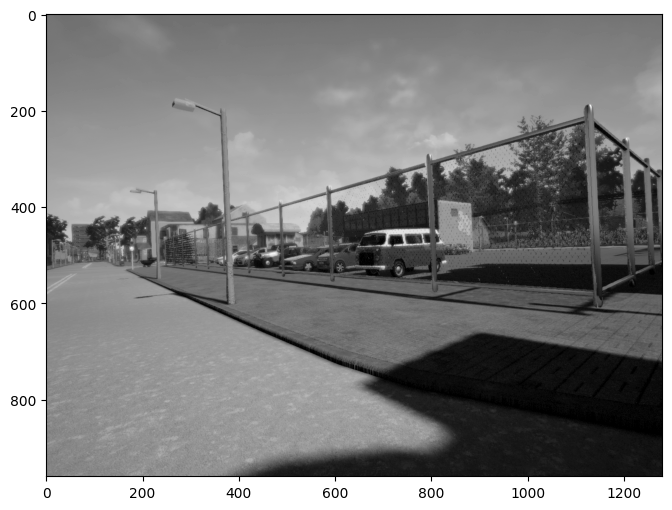

In [4]:
image = dataset_handler.images[30]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

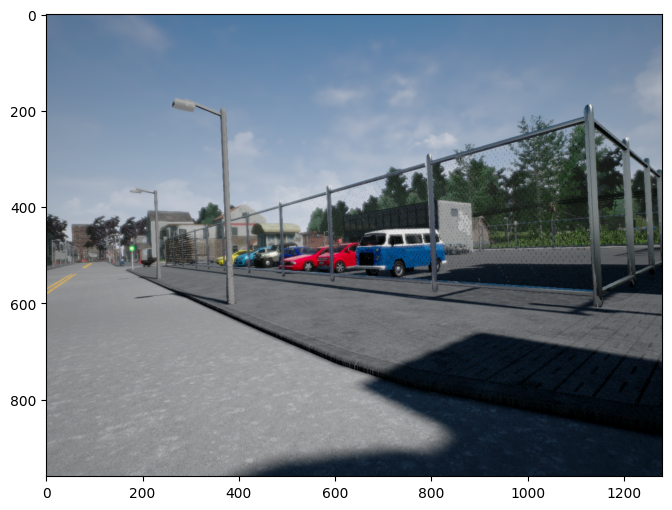

In [5]:
image_rgb = dataset_handler.images_rgb[30]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image_rgb)

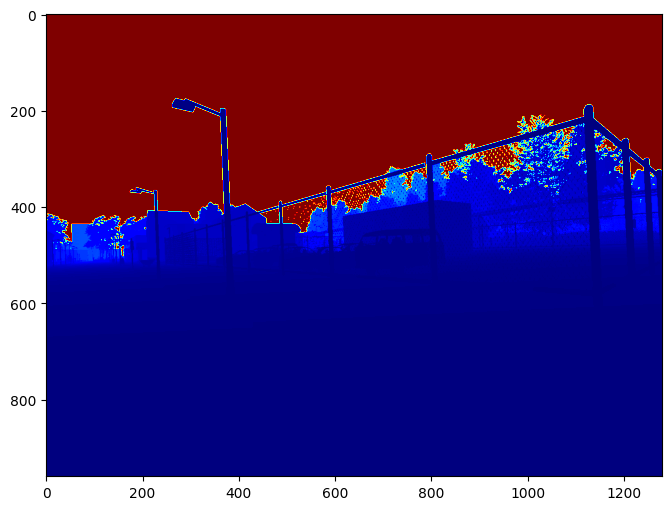

In [6]:
i = 30
depth = dataset_handler.depth_maps[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(depth, cmap='jet')

In [7]:
dataset_handler.k

array([[640.,   0., 640.],
       [  0., 480., 480.],
       [  0.,   0.,   1.]], dtype=float32)

In order to access an arbitrary frame use image index, as shown in the examples below. Make sure the indexes are within the number of frames in the dataset. The number of frames in the dataset can be accessed with num_frames attribute.

In [8]:
# Number of frames in the dataset
print(dataset_handler.num_frames)

52


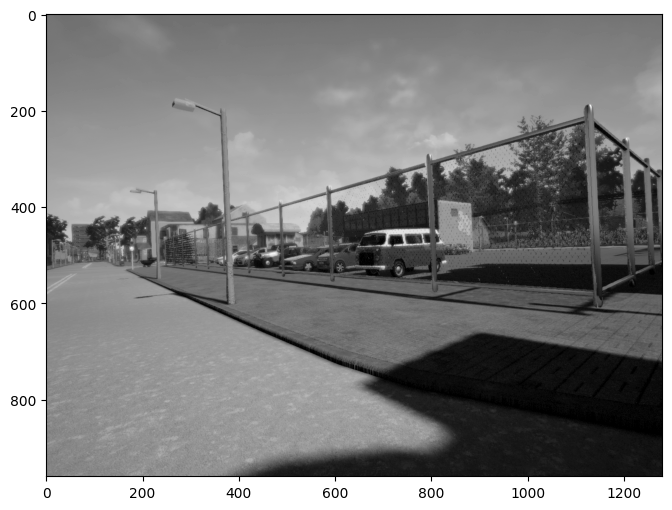

In [9]:
i = 30
image = dataset_handler.images[i]

plt.figure(figsize=(8, 6), dpi=100)
plt.imshow(image, cmap='gray')

## 1 - Feature Extraction

### 1.1 - Extracting Features from an Image

**Task**: Implement feature extraction from a single image. You can use any feature descriptor of your choice.

***Optional***: Try to extract features with different descriptors such as SIFT, ORB, SURF and BRIEF. You can also try using detectors such as Harris corners or FAST and pairing them with a descriptor. Lastly, try changing parameters of the algorithms. Do you see the difference in various approaches?
You might find this link useful:  [OpenCV:Feature Detection and Description](https://docs.opencv.org/3.4.3/db/d27/tutorial_py_table_of_contents_feature2d.html).

# Change Feature Descriptors

In [ ]:
!pip install opencv-contrib-python==4.5.5.64

In [70]:
def extract_features(image, method="ORB"):
    """
    Find keypoints and descriptors for the image using the specified method.

    Arguments:
    image -- a grayscale image
    method -- the feature detection method to use ("ORB", "SIFT", "SURF", "BRIEF")

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if method == "ORB":
        detector = cv2.ORB_create()
        kp, des = detector.detectAndCompute(image, None)
    elif method == "SIFT":
        detector = cv2.SIFT_create()
        kp, des = detector.detectAndCompute(image, None)
    elif method == "BRIEF":
        fast = cv2.FastFeatureDetector_create()
        brief = cv2.xfeatures2d.BriefDescriptorExtractor_create()
        kp = fast.detect(image, None)
        kp, des = brief.compute(image, kp)
        return kp, des
    else:
        raise ValueError(f"Unknown method: {method}")

    return kp, des

In [71]:
# Test with different methods
i = 1
image = dataset_handler.images[i]

kp, des = extract_features(image, method="ORB")
print(f"Method: ORB")
print(f"Number of features detected in frame {i}: {len(kp)}")
print(f"Coordinates of the first keypoint in frame {i}: {kp[0].pt if kp else 'None'}\n")

kp, des = extract_features(image, method="SIFT")
print(f"Method: SIFT")
print(f"Number of features detected in frame {i}: {len(kp)}")
print(f"Coordinates of the first keypoint in frame {i}: {kp[0].pt if kp else 'None'}\n")

kp, des = extract_features(image, method="BRIEF")
print(f"Method: BRIEF")
print(f"Number of features detected in frame {i}: {len(kp)}")
print(f"Coordinates of the first keypoint in frame {i}: {kp[0].pt if kp else 'None'}\n")

Method: ORB
Number of features detected in frame 1: 500
Coordinates of the first keypoint in frame 1: (301.0, 400.0)

Method: SIFT
Number of features detected in frame 1: 1528
Coordinates of the first keypoint in frame 1: (4.418116569519043, 383.1223449707031)

Method: BRIEF
Number of features detected in frame 1: 8175
Coordinates of the first keypoint in frame 1: (1179.0, 29.0)



In [72]:
def visualize_features(image, kp):
    """
    Visualize extracted features in the image

    Arguments:
    image -- a grayscale image
    kp -- list of the extracted keypoints

    Returns:
    """
    display = cv2.drawKeypoints(image, kp, None)
    plt.imshow(display)

Method: ORB
Number of features detected: 500


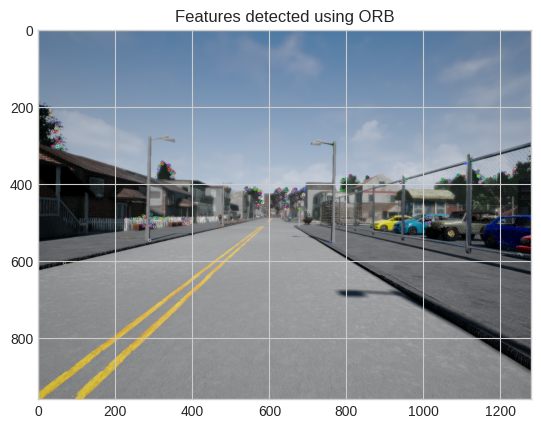

Method: SIFT
Number of features detected: 1953


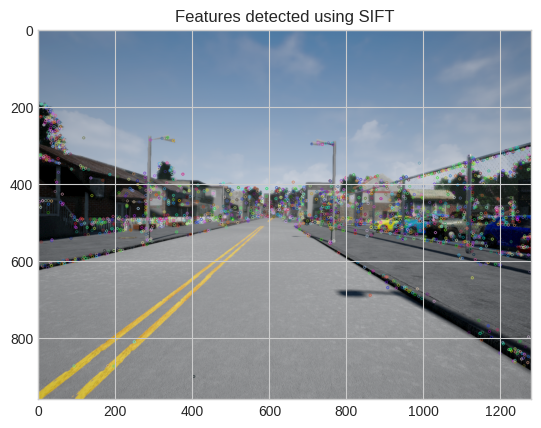

Method: BRIEF
Number of features detected: 9895


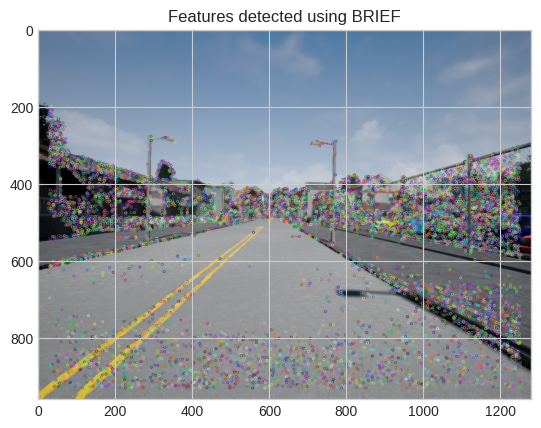

In [73]:
# Feature Descriptor 목록
methods = ["ORB", "SIFT", "BRIEF"]

# 특정 이미지를 선택
i = 50
image = dataset_handler.images_rgb[i]  # RGB 이미지를 그대로 사용

# 각 Feature Descriptor의 결과를 시각화
for method in methods:
    kp, des = extract_features(image, method=method)
    print(f"Method: {method}")
    print(f"Number of features detected: {len(kp)}")

    # 시각화
    visualize_features(image, kp)  # RGB 이미지를 그대로 시각화
    plt.title(f"Features detected using {method}")
    plt.show()


### USING SIFT

### 1.2 - Extracting Features from Each Image in the Dataset using SIFT

**Task**: Implement feature extraction for each image in the dataset with the function you wrote in the above section.

In [16]:
def extract_features_dataset(images, extract_features_function, method="ORB"):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images

    """
    kp_list = []
    des_list = []

    for image in images:
        kp, des = extract_features_function(image, method=method)
        kp_list.append(kp)
        des_list.append(des)


    return kp_list, des_list

In [28]:
images = dataset_handler.images
methods = ["SIFT"]

i = 5

print(f"Method: {method}\n")

# 데이터셋의 특징점과 디스크립터 추출
kp_list, des_list = extract_features_dataset(images, extract_features, method=method)

# 특정 프레임의 특징점 정보 출력
i = 5  # 확인할 이미지 프레임 인덱스
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp_list[i][0].pt)))

# 전체 이미지와 추출된 특징점 개수 확인
print("Length of images array: {0}\n".format(len(images)))

Method: SIFT

Number of features detected in frame 5: 1691
Coordinates of the first keypoint in frame 5: (4.316969394683838, 390.11468505859375)
Length of images array: 52



## 2 - Feature Matching using SIFT

Next step after extracting the features in each image is matching the features from the subsequent frames. This is what is needed to be done in this section.

### 2.1 - Matching Features from a Pair of Subsequent Frames

**Task**: Implement feature matching for a pair of images. You can use any feature matching algorithm, Brute Force Matching or FLANN based Matching for example.

***Optional 1***: Implement match filtering by thresholding the distance between the best matches. This might be useful for improving your overall trajectory estimation results. Recall that you have an option of specifying the number best matches to be returned by the matcher.


In [29]:
def match_features(des1, des2, method="ORB"):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    # Create BFMatcher object
    if method in ["ORB", "BRIEF"]:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    elif method in ["SIFT"]:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    else:
        raise ValueError(f"Unsupported method: {method}")

    # Match descriptors
    match = bf.match(des1, des2)

    # Sort them in the order of their distance
    match = sorted(match, key=lambda x: x.distance)

    ### END CODE HERE ###

    return match

In [30]:
methods = ["SIFT"]

i = 0
des1 = des_list[i]
des2 = des_list[i+1]

for method in methods:
  match = match_features(des1, des2, method=method)
  print(f"Method: {method}")
  print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Method: SIFT
Number of features matched in frames 0 and 1: 778


In [33]:
def filter_matches_distance(match, dist_threshold, method="ORB"):
    """
    Filter matched features from two images by distance between the best matches.

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches
    method -- the feature descriptor method used ("ORB", "SIFT", "BRIEF")

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []

    ### START CODE HERE ###
    # Adjust the threshold for different methods if necessary
    for m in match:
        # Different distance thresholds for each method
        if method in ["ORB", "BRIEF"]:  # Hamming distance
            if m.distance < dist_threshold:
                filtered_match.append(m)
        elif method in ["SIFT"]:  # L2 distance
            if m.distance < dist_threshold:
                filtered_match.append(m)
        else:
            raise ValueError(f"Unsupported method: {method}")
    ### END CODE HERE ###

    return filtered_match


In [49]:
i = 0
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2, method="SIFT")

dist_threshold = 35
filtered_match = filter_matches_distance(match, dist_threshold)

print("Method: SIFT")
print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Method: SIFT
Number of features matched in frames 0 and 1 after filtering by distance: 20


In [50]:
def visualize_matches(image1, kp1, image2, kp2, match, method="ORB"):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    plt.axis('off')
    plt.show()

Method: SIFT


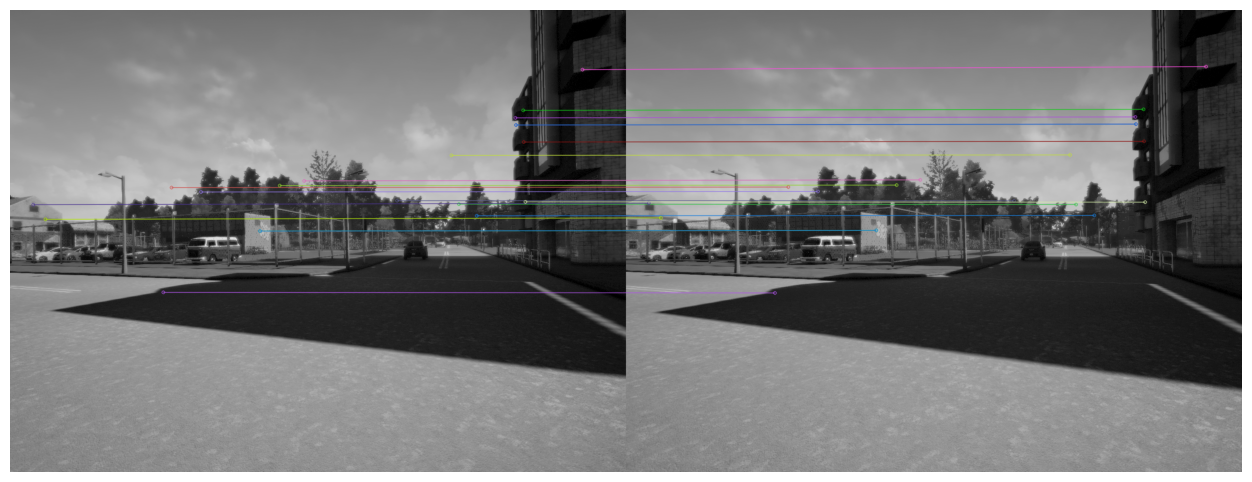

In [51]:
n=20
filtering = False

i = 0
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]
print("Method: SIFT")
match = match_features(des1, des2, method="SIFT")
if filtering:
    dist_threshold = 10
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])

### 2.2 - Matching Features in Each Subsequent Image Pair in the Dataset

**Task**: Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.

***Optional***: Implement match filtering by thresholding the distance for each subsequent image pair in the dataset with the function you wrote in the above section.

In [53]:
def match_features_dataset(des_list, match_features, method="ORB"):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1

    """
    matches = []

    ### START CODE HERE ###
    for i in range(len(des_list) - 1):
        match = match_features(des_list[i], des_list[i + 1], method=method)
        matches.append(match)


    ### END CODE HERE ###

    return matches

In [54]:
matches = match_features_dataset(des_list, match_features,method="SIFT")

i = 5
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 5 and 6: 827


In [55]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold, method="ORB"):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0)

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset.
                        Each matches[i] is a list of good matches, satisfying the distance threshold

    """
    filtered_matches = []

    ### START CODE HERE ###
    for match in matches:
        filtered = filter_matches_distance(match, dist_threshold, method=method)
        filtered_matches.append(filtered)

    ### END CODE HERE ###

    return filtered_matches

In [57]:
# Optional
methods = ["SIFT"]
dist_thresholds = {"ORB": 10, "SIFT": 35, "BRIEF": 10}

for method in methods:
  matches = match_features_dataset(des_list, match_features, method=method)

  # 매칭 필터링 수행
  filtered_matches = filter_matches_dataset(
        filter_matches_distance,
        matches,
        dist_threshold=dist_thresholds[method],
        method=method
    )
  if len(filtered_matches) > 0:
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = False
    if is_main_filtered_m:
      matches = filtered_matches

    i = 0
    print(f"Method {method}\n")
    print("Number of filtered matches in frames {0} and {1}: {2}\n".format(i, i+1, len(filtered_matches[i])))

Method SIFT

Number of filtered matches in frames 0 and 1: 20



## 3 - Trajectory Estimation

At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images

**Task**: Implement camera motion estimation from a pair of images. You can use the motion estimation algorithm, such as Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.

- If you decide to use PnP, you will need depth maps of frame and they are provided with the dataset handler.
- Here, we decide to use Essential Matrix Decomposition, more information about this method can be found in [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).
- When you derive R,t, use the open-cv function such as cv2.findEssentialMat and cv2.recoverPose.
- In cv2.findEssentialMat, set the method=cv2.RANSAC, prob = 0.999, and threshold=1.0.

In [58]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix

    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are
                     coordinates of the i-th match in the image coordinate system

    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []

    ### START CODE HERE ###
    for m in match:
        image1_points.append(kp1[m.queryIdx].pt)
        image2_points.append(kp2[m.trainIdx].pt)

    image1_points = np.array(image1_points, dtype=np.float32)
    image2_points = np.array(image2_points, dtype=np.float32)


    # Estimate the Essential matrix
    essential_matrix, _ = cv2.findEssentialMat(image1_points, image2_points, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Decompose the Essential matrix to obtain rotation and translation
    _, rmat, tvec, _ = cv2.recoverPose(essential_matrix, image1_points, image2_points, k)


    ### END CODE HERE ###

    return rmat, tvec, image1_points, image2_points

In [59]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 9.99989030e-01 -4.67597507e-03  2.72826445e-04]
 [ 4.67613663e-03  9.99988890e-01 -5.94587805e-04]
 [-2.70043136e-04  5.95857056e-04  9.99999786e-01]]
Estimated translation:
 [[ 0.00978757]
 [ 0.00438211]
 [-0.9999425 ]]


**Expected Output Format**:

Make sure that your estimated rotation matrix and translation vector are in the same format as the given initial values

```
rmat = np.eye(3)
tvec = np.zeros((3, 1))

print("Initial rotation:\n {0}".format(rmat))
print("Initial translation:\n {0}".format(tvec))
```


```
Initial rotation:
 [[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]
Initial translation:
 [[0.]
 [0.]
 [0.]]
```

**Camera Movement Visualization**:
You can use `visualize_camera_movement` that is provided to you. This function visualizes final image matches from an image pair connected with an arrow corresponding to direction of camera movement (when `is_show_img_after_mov = False`). The function description:
```
Arguments:
image1 -- the first image in a matched image pair (RGB or grayscale)
image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [x, y], where x and y are
                 coordinates of the i-th match in the image coordinate system
image2 -- the second image in a matched image pair (RGB or grayscale)
image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [x, y], where x and y are
                 coordinates of the i-th match in the image coordinate system
is_show_img_after_mov -- a boolean variable, controling the output (read image_move description for more info)

Returns:
image_move -- an image with the visualization. When is_show_img_after_mov=False then the image points from both images are visualized on the first image. Otherwise, the image points from the second image only are visualized on the second image
```

In [60]:
i=30
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

Output hidden; open in https://colab.research.google.com to view.

In [61]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

Output hidden; open in https://colab.research.google.com to view.

### 3.2 - Camera Trajectory Estimation

**Task**: Implement camera trajectory estimation with visual odometry. More specifically, implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.

***Note***: Do not forget that the image pairs are not independent one to each other. i-th and (i + 1)-th image pairs have an image in common

In [62]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix

    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and
                  trajectory[:, i] is a 3x1 numpy vector, such as:

                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location

                  * Consider that the origin of your trajectory cordinate system is located at the camera position
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven
                  at the initialization of this function

    """
    trajectory = [np.zeros((3, 1))]  # Start with the origin point as a list element
    current_position = np.zeros((3, 1))  # Initial position at the origin

    ### START CODE HERE ###
    for i in range(len(matches)):

        # estimate the rmat, tvec
        rmat, tvec, _, _ = estimate_motion(matches[i], kp_list[i], kp_list[i + 1], k)

        # Update current position by applying the rotation and translation
        current_position += np.dot(rmat, tvec)

        # Append the new position to the trajectory list
        trajectory.append(current_position.copy())

    # Convert trajectory to a numpy array of shape (3, len)
    trajectory = np.hstack(trajectory)


    ### END CODE HERE ###

    return trajectory

In [63]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 1 is: 
 [[ 0.00949416]
 [ 0.00502238]
 [-0.99994232]]

Length of trajectory: 52


**Expected Output**:

```
Camera location in point i is:
 [[locXi]
 [locYi]
 [locZi]]```

 In this output: locXi, locYi, locZi are the coordinates of the corresponding i-th camera location

In [64]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 100
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches


# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.00000000e+00 -3.08895629e-01 -4.36678753e-02 -2.62094685e-03
   3.98672071e-02  2.52025977e-01  3.33299662e-01 -9.21129264e-03
   2.17042096e-01 -1.00784670e-01 -8.05424654e-01 -7.93646199e-01
  -6.17224735e-01 -8.69308462e-02 -3.99124049e-01 -1.98490367e-01
  -1.11719177e-01  8.31719738e-03  1.15365305e-01  3.08720767e-01
   3.52953070e-01  4.25012454e-01  4.75877586e-01 -1.13081394e-01
   6.85347736e-02  1.71499678e-01  6.52908725e-01  5.11344961e-01
   5.31789105e-01  6.61109957e-01  7.58694284e-01  1.71176916e+00
   1.65822727e+00  1.73489491e+00  1.85629250e+00  2.25826283e+00
   2.61259152e+00  2.90570939e+00  3.31014214e+00  3.49884823e+00
   3.49522339e+00  3.64717258e+00  3.98763013e+00  4.25512018e+00
   4.57271177e+00  4.37450687e+00  4.52995432e+00  4.25632283e+00
   4.14670901e+00  4.30569490e+00  4.78041287e+00  4.91636305e+00]]
Trajectory Y:
 [[ 0.         -0.12980523 -0.11107584 -0.14297303 -0.20254354 -0.24194512
  -0.30541749 -0.1978844  -0.2005588

### Visualize your Results

**Important**:

- Make sure your results visualization is appealing before submitting your results.

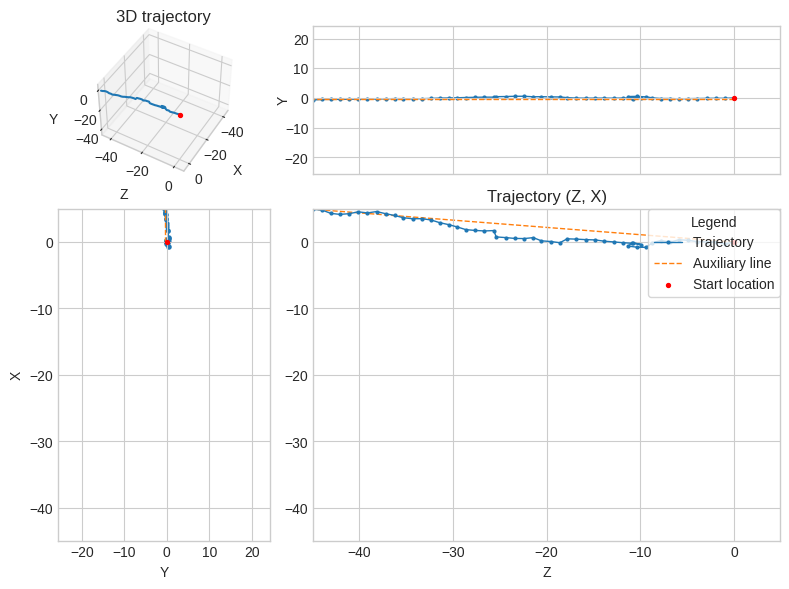

In [65]:
visualize_trajectory(trajectory)

In [66]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

locX, locY, locZ = [], [], []

# Set up the figure
fig = plt.figure(figsize=(8, 6), dpi=100)
gspec = gridspec.GridSpec(3, 3)
ZY_plt = plt.subplot(gspec[0, 1:])
YX_plt = plt.subplot(gspec[1:, 0])
traj_main_plt = plt.subplot(gspec[1:, 1:])
D3_plt = plt.subplot(gspec[0, 0], projection='3d')

# Determine plot limits
max_value = np.max(trajectory)
min_value = np.min(trajectory)
maxY, minY = max_value, min_value

def animate(i):
    current_pos = trajectory[:, i]
    print(f"Frame {i}: {current_pos}")  # 프레임 번호와 현재 포지션 출력
    locX.append(current_pos[0])
    locY.append(current_pos[1])
    locZ.append(current_pos[2])

    traj_main_plt.clear()
    ZY_plt.clear()
    YX_plt.clear()
    D3_plt.clear()

    # Main trajectory plot (Z, X)
    traj_main_plt.set_title("Autonomous vehicle trajectory (Z, X)", y=1.06)
    traj_main_plt.plot(locZ, locX, ".-", label="Trajectory", zorder=1, linewidth=1, markersize=4)
    traj_main_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    traj_main_plt.set_xlim([min_value, max_value])
    traj_main_plt.set_ylim([min_value, max_value])
    traj_main_plt.set_xlabel("Z")
    traj_main_plt.legend(loc=1, title="Legend", borderaxespad=0., fontsize="medium", frameon=True)

    # ZY plot
    ZY_plt.plot(locZ, locY, ".-", linewidth=1, markersize=4, zorder=0)
    ZY_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    ZY_plt.set_xlim([min_value, max_value])
    ZY_plt.set_ylim([minY, maxY])
    ZY_plt.set_ylabel("Y")
    ZY_plt.axes.xaxis.set_ticklabels([])

    # YX plot
    YX_plt.plot(locY, locX, ".-", linewidth=1, markersize=4, zorder=0)
    YX_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    YX_plt.set_xlim([minY, maxY])
    YX_plt.set_ylim([min_value, max_value])
    YX_plt.set_xlabel("Y")
    YX_plt.set_ylabel("X")

    # 3D plot
    D3_plt.plot3D(locX, locZ, locY, zorder=0)
    D3_plt.scatter(0, 0, 0, s=8, c="red", zorder=1)
    D3_plt.set_xlim3d(min_value, max_value)
    D3_plt.set_ylim3d(min_value, max_value)
    D3_plt.set_zlim3d(min_value, max_value)
    D3_plt.set_xlabel("X", labelpad=0)
    D3_plt.set_ylabel("Z", labelpad=0)
    D3_plt.set_zlabel("Y", labelpad=-2)
    D3_plt.view_init(45, azim=30)

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=trajectory.shape[1], interval=100, repeat=True)
HTML(ani.to_jshtml())
# plt.tight_layout()
# plt.show()

Output hidden; open in https://colab.research.google.com to view.

### USING BRIEF

### 1.2 - Extracting Features from Each Image in the Dataset using BRIEF

**Task**: Implement feature extraction for each image in the dataset with the function you wrote in the above section.

In [74]:
def extract_features_dataset(images, extract_features_function, method="ORB"):
    """
    Find keypoints and descriptors for each image in the dataset

    Arguments:
    images -- a list of grayscale images
    extract_features_function -- a function which finds features (keypoints and descriptors) for an image

    Returns:
    kp_list -- a list of keypoints for each image in images
    des_list -- a list of descriptors for each image in images

    """
    kp_list = []
    des_list = []

    for image in images:
        kp, des = extract_features_function(image, method=method)
        kp_list.append(kp)
        des_list.append(des)


    return kp_list, des_list

In [75]:
images = dataset_handler.images
methods = ["BRIEF"]

i = 5

print(f"Method: {method}\n")

# 데이터셋의 특징점과 디스크립터 추출
kp_list, des_list = extract_features_dataset(images, extract_features, method=method)

# 특정 프레임의 특징점 정보 출력
i = 5  # 확인할 이미지 프레임 인덱스
print("Number of features detected in frame {0}: {1}".format(i, len(kp_list[i])))
print("Coordinates of the first keypoint in frame {0}: {1}".format(i, str(kp_list[i][0].pt)))

# 전체 이미지와 추출된 특징점 개수 확인
print("Length of images array: {0}\n".format(len(images)))

Method: BRIEF

Number of features detected in frame 5: 8065
Coordinates of the first keypoint in frame 5: (1244.0, 29.0)
Length of images array: 52



## 2 - Feature Matching using BRIEF

Next step after extracting the features in each image is matching the features from the subsequent frames. This is what is needed to be done in this section.

### 2.1 - Matching Features from a Pair of Subsequent Frames

**Task**: Implement feature matching for a pair of images. You can use any feature matching algorithm, Brute Force Matching or FLANN based Matching for example.

***Optional 1***: Implement match filtering by thresholding the distance between the best matches. This might be useful for improving your overall trajectory estimation results. Recall that you have an option of specifying the number best matches to be returned by the matcher.


In [76]:
def match_features(des1, des2, method="ORB"):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image

    Returns:
    match -- list of matched features from two images. Each match[i] is k or less matches for the same query descriptor
    """
    ### START CODE HERE ###
    # Create BFMatcher object
    if method in ["ORB", "BRIEF"]:
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
    elif method in ["SIFT"]:
      bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    else:
        raise ValueError(f"Unsupported method: {method}")

    # Match descriptors
    match = bf.match(des1, des2)

    # Sort them in the order of their distance
    match = sorted(match, key=lambda x: x.distance)

    ### END CODE HERE ###

    return match

In [77]:
methods = ["BRIEF"]

i = 0
des1 = des_list[i]
des2 = des_list[i+1]

for method in methods:
  match = match_features(des1, des2, method=method)
  print(f"Method: {method}")
  print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(match)))

# Remember that a matcher finds the best matches for EACH descriptor from a query set

Method: BRIEF
Number of features matched in frames 0 and 1: 4321


In [78]:
def filter_matches_distance(match, dist_threshold, method="ORB"):
    """
    Filter matched features from two images by distance between the best matches.

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches
    method -- the feature descriptor method used ("ORB", "SIFT", "BRIEF")

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []

    ### START CODE HERE ###
    # Adjust the threshold for different methods if necessary
    for m in match:
        # Different distance thresholds for each method
        if method in ["ORB", "BRIEF"]:  # Hamming distance
            if m.distance < dist_threshold:
                filtered_match.append(m)
        elif method in ["SIFT"]:  # L2 distance
            if m.distance < dist_threshold:
                filtered_match.append(m)
        else:
            raise ValueError(f"Unsupported method: {method}")
    ### END CODE HERE ###

    return filtered_match

In [83]:
i = 0
des1 = des_list[i]
des2 = des_list[i+1]
match = match_features(des1, des2, method="BRIEF")

dist_threshold = 5
filtered_match = filter_matches_distance(match, dist_threshold)

print("Method: BRIEF")
print("Number of features matched in frames {0} and {1} after filtering by distance: {2}".format(i, i+1, len(filtered_match)))

Method: BRIEF
Number of features matched in frames 0 and 1 after filtering by distance: 180


In [84]:
def visualize_matches(image1, kp1, image2, kp2, match, method="ORB"):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)
    plt.axis('off')
    plt.show()

Method: BRIEF


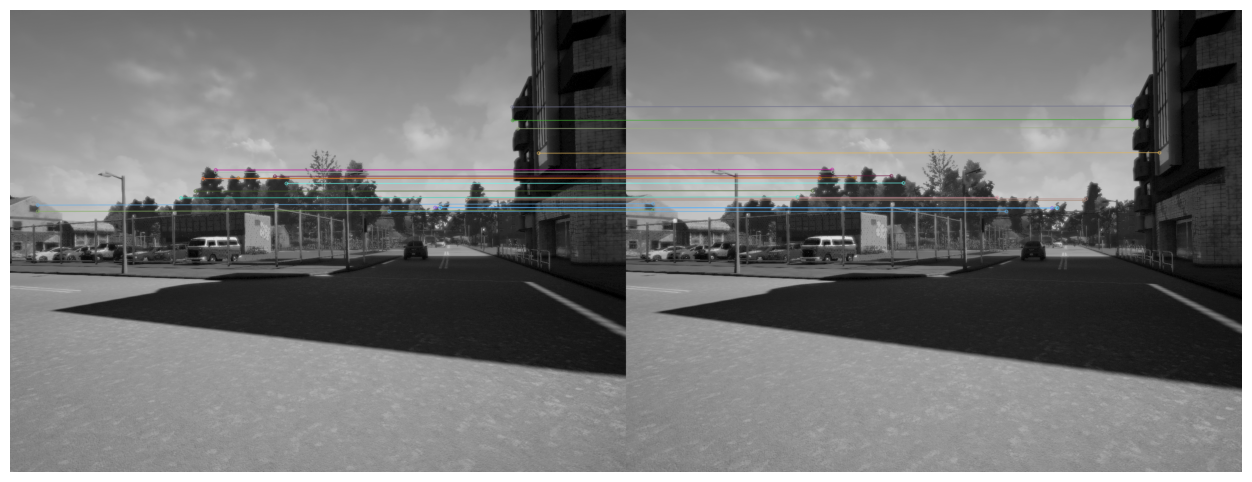

In [85]:
n=20
filtering = False

i = 0
image1 = dataset_handler.images[i]
image2 = dataset_handler.images[i+1]

kp1 = kp_list[i]
kp2 = kp_list[i+1]

des1 = des_list[i]
des2 = des_list[i+1]
print("Method: BRIEF")
match = match_features(des1, des2, method="BRIEF")
if filtering:
    dist_threshold = 10
    match = filter_matches_distance(match, dist_threshold)

image_matches = visualize_matches(image1, kp1, image2, kp2, match[:n])

### 2.2 - Matching Features in Each Subsequent Image Pair in the Dataset

**Task**: Implement feature matching for each subsequent image pair in the dataset with the function you wrote in the above section.

***Optional***: Implement match filtering by thresholding the distance for each subsequent image pair in the dataset with the function you wrote in the above section.

In [86]:
def match_features_dataset(des_list, match_features, method="ORB"):
    """
    Match features for each subsequent image pair in the dataset

    Arguments:
    des_list -- a list of descriptors for each image in the dataset
    match_features -- a function which maches features between a pair of images

    Returns:
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1

    """
    matches = []

    ### START CODE HERE ###
    for i in range(len(des_list) - 1):
        match = match_features(des_list[i], des_list[i + 1], method=method)
        matches.append(match)


    ### END CODE HERE ###

    return matches

In [87]:
matches = match_features_dataset(des_list, match_features,method="BRIEF")

i = 5
print("Number of features matched in frames {0} and {1}: {2}".format(i, i+1, len(matches[i])))

Number of features matched in frames 5 and 6: 4165


In [88]:
# Optional
def filter_matches_dataset(filter_matches_distance, matches, dist_threshold, method="ORB"):
    """
    Filter matched features by distance for each subsequent image pair in the dataset

    Arguments:
    filter_matches_distance -- a function which filters matched features from two images by distance between the best matches
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0)

    Returns:
    filtered_matches -- list of good matches for each subsequent image pair in the dataset.
                        Each matches[i] is a list of good matches, satisfying the distance threshold

    """
    filtered_matches = []

    ### START CODE HERE ###
    for match in matches:
        filtered = filter_matches_distance(match, dist_threshold, method=method)
        filtered_matches.append(filtered)

    ### END CODE HERE ###

    return filtered_matches

In [89]:
# Optional
methods = ["BRIEF"]
dist_thresholds = {"BRIEF": 5}

for method in methods:
  matches = match_features_dataset(des_list, match_features, method=method)

  # 매칭 필터링 수행
  filtered_matches = filter_matches_dataset(
        filter_matches_distance,
        matches,
        dist_threshold=dist_thresholds[method],
        method=method
    )
  if len(filtered_matches) > 0:
    # Make sure that this variable is set to True if you want to use filtered matches further in your assignment
    is_main_filtered_m = False
    if is_main_filtered_m:
      matches = filtered_matches

    i = 0
    print(f"Method {method}\n")
    print("Number of filtered matches in frames {0} and {1}: {2}\n".format(i, i+1, len(filtered_matches[i])))

Method BRIEF

Number of filtered matches in frames 0 and 1: 180



## 3 - Trajectory Estimation

At this point you have everything to perform visual odometry for the autonomous vehicle. In this section you will incrementally estimate the pose of the vehicle by examining the changes that motion induces on the images of its onboard camera.

### 3.1 - Estimating Camera Motion between a Pair of Images

**Task**: Implement camera motion estimation from a pair of images. You can use the motion estimation algorithm, such as Perspective-n-Point (PnP), as well as Essential Matrix Decomposition.

- If you decide to use PnP, you will need depth maps of frame and they are provided with the dataset handler.
- Here, we decide to use Essential Matrix Decomposition, more information about this method can be found in [Wikipedia: Determining R and t from E](https://en.wikipedia.org/wiki/Essential_matrix).
- When you derive R,t, use the open-cv function such as cv2.findEssentialMat and cv2.recoverPose.
- In cv2.findEssentialMat, set the method=cv2.RANSAC, prob = 0.999, and threshold=1.0.

In [90]:
def estimate_motion(match, kp1, kp2, k, depth1=None):
    """
    Estimate camera motion from a pair of subsequent image frames

    Arguments:
    match -- list of matched features from the pair of images
    kp1 -- list of the keypoints in the first image
    kp2 -- list of the keypoints in the second image
    k -- camera calibration matrix

    Optional arguments:
    depth1 -- a depth map of the first frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    rmat -- recovered 3x3 rotation numpy matrix
    tvec -- recovered 3x1 translation numpy vector
    image1_points -- a list of selected match coordinates in the first image. image1_points[i] = [u, v], where u and v are
                     coordinates of the i-th match in the image coordinate system
    image2_points -- a list of selected match coordinates in the second image. image1_points[i] = [u, v], where u and v are
                     coordinates of the i-th match in the image coordinate system

    """
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    image1_points = []
    image2_points = []

    ### START CODE HERE ###
    for m in match:
        image1_points.append(kp1[m.queryIdx].pt)
        image2_points.append(kp2[m.trainIdx].pt)

    image1_points = np.array(image1_points, dtype=np.float32)
    image2_points = np.array(image2_points, dtype=np.float32)


    # Estimate the Essential matrix
    essential_matrix, _ = cv2.findEssentialMat(image1_points, image2_points, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)

    # Decompose the Essential matrix to obtain rotation and translation
    _, rmat, tvec, _ = cv2.recoverPose(essential_matrix, image1_points, image2_points, k)


    ### END CODE HERE ###

    return rmat, tvec, image1_points, image2_points

In [91]:
i = 0
match = matches[i]
kp1 = kp_list[i]
kp2 = kp_list[i+1]
k = dataset_handler.k
depth = dataset_handler.depth_maps[i]

rmat, tvec, image1_points, image2_points = estimate_motion(match, kp1, kp2, k, depth1=depth)

print("Estimated rotation:\n {0}".format(rmat))
print("Estimated translation:\n {0}".format(tvec))

Estimated rotation:
 [[ 0.99998595 -0.00445849  0.00286657]
 [ 0.00446476  0.99998765 -0.00218389]
 [-0.00285679  0.00219666  0.99999351]]
Estimated translation:
 [[ 0.02372681]
 [ 0.00508362]
 [-0.99970555]]


In [92]:
i=30
image1  = dataset_handler.images_rgb[i]
image2 = dataset_handler.images_rgb[i + 1]

image_move = visualize_camera_movement(image1, image1_points, image2, image2_points)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)

Output hidden; open in https://colab.research.google.com to view.

In [93]:
image_move = visualize_camera_movement(image1, image1_points, image2, image2_points, is_show_img_after_move=True)
plt.figure(figsize=(16, 12), dpi=100)
plt.imshow(image_move)
# These visualizations might be helpful for understanding the quality of image points selected for the camera motion estimation

Output hidden; open in https://colab.research.google.com to view.

### 3.2 - Camera Trajectory Estimation

**Task**: Implement camera trajectory estimation with visual odometry. More specifically, implement camera motion estimation for each subsequent image pair in the dataset with the function you wrote in the above section.

***Note***: Do not forget that the image pairs are not independent one to each other. i-th and (i + 1)-th image pairs have an image in common

In [94]:
def estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=[]):
    """
    Estimate complete camera trajectory from subsequent image pairs

    Arguments:
    estimate_motion -- a function which estimates camera motion from a pair of subsequent image frames
    matches -- list of matches for each subsequent image pair in the dataset.
               Each matches[i] is a list of matched features from images i and i + 1
    des_list -- a list of keypoints for each image in the dataset
    k -- camera calibration matrix

    Optional arguments:
    depth_maps -- a list of depth maps for each frame. This argument is not needed if you use Essential Matrix Decomposition

    Returns:
    trajectory -- a 3xlen numpy array of the camera locations, where len is the lenght of the list of images and
                  trajectory[:, i] is a 3x1 numpy vector, such as:

                  trajectory[:, i][0] - is X coordinate of the i-th location
                  trajectory[:, i][1] - is Y coordinate of the i-th location
                  trajectory[:, i][2] - is Z coordinate of the i-th location

                  * Consider that the origin of your trajectory cordinate system is located at the camera position
                  when the first image (the one with index 0) was taken. The first camera location (index = 0) is geven
                  at the initialization of this function

    """
    trajectory = [np.zeros((3, 1))]  # Start with the origin point as a list element
    current_position = np.zeros((3, 1))  # Initial position at the origin

    ### START CODE HERE ###
    for i in range(len(matches)):

        # estimate the rmat, tvec
        rmat, tvec, _, _ = estimate_motion(matches[i], kp_list[i], kp_list[i + 1], k)

        # Update current position by applying the rotation and translation
        current_position += np.dot(rmat, tvec)

        # Append the new position to the trajectory list
        trajectory.append(current_position.copy())

    # Convert trajectory to a numpy array of shape (3, len)
    trajectory = np.hstack(trajectory)


    ### END CODE HERE ###

    return trajectory

In [95]:
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)

i = 1
print("Camera location in point {0} is: \n {1}\n".format(i, trajectory[:, [i]]))

# Remember that the length of the returned by trajectory should be the same as the length of the image array
print("Length of trajectory: {0}".format(trajectory.shape[1]))

Camera location in point 1 is: 
 [[ 0.02083809]
 [ 0.00737274]
 [-0.99975568]]

Length of trajectory: 52


In [96]:
# Note: Make sure to uncomment the below line if you modified the original data in any ways
#dataset_handler = DatasetHandler()


# Part 1. Features Extraction
images = dataset_handler.images
kp_list, des_list = extract_features_dataset(images, extract_features)


# Part II. Feature Matching
matches = match_features_dataset(des_list, match_features)

# Set to True if you want to use filtered matches or False otherwise
is_main_filtered_m = True
if is_main_filtered_m:
    dist_threshold = 100
    filtered_matches = filter_matches_dataset(filter_matches_distance, matches, dist_threshold)
    matches = filtered_matches


# Part III. Trajectory Estimation
depth_maps = dataset_handler.depth_maps
trajectory = estimate_trajectory(estimate_motion, matches, kp_list, k, depth_maps=depth_maps)


#!!! Make sure you don't modify the output in any way
# Print Submission Info
print("Trajectory X:\n {0}".format(trajectory[0,:].reshape((1,-1))))
print("Trajectory Y:\n {0}".format(trajectory[1,:].reshape((1,-1))))
print("Trajectory Z:\n {0}".format(trajectory[2,:].reshape((1,-1))))

Trajectory X:
 [[ 0.00000000e+00 -3.08895629e-01 -4.36678753e-02 -2.62094685e-03
   3.98672071e-02  2.52025977e-01  3.33299662e-01 -9.21129264e-03
   2.17042096e-01 -1.00784670e-01 -8.05424654e-01 -7.93646199e-01
  -6.17224735e-01 -8.69308462e-02 -3.99124049e-01 -1.98490367e-01
  -1.11719177e-01  8.31719738e-03  1.15365305e-01  3.08720767e-01
   3.52953070e-01  4.25012454e-01  4.75877586e-01 -1.13081394e-01
   6.85347736e-02  1.71499678e-01  6.52908725e-01  5.11344961e-01
   5.31789105e-01  6.61109957e-01  7.58694284e-01  1.71176916e+00
   1.65822727e+00  1.73489491e+00  1.85629250e+00  2.25826283e+00
   2.61259152e+00  2.90570939e+00  3.31014214e+00  3.49884823e+00
   3.49522339e+00  3.64717258e+00  3.98763013e+00  4.25512018e+00
   4.57271177e+00  4.37450687e+00  4.52995432e+00  4.25632283e+00
   4.14670901e+00  4.30569490e+00  4.78041287e+00  4.91636305e+00]]
Trajectory Y:
 [[ 0.         -0.12980523 -0.11107584 -0.14297303 -0.20254354 -0.24194512
  -0.30541749 -0.1978844  -0.2005588

### Visualize your Results

**Important**:

- Make sure your results visualization is appealing before submitting your results.

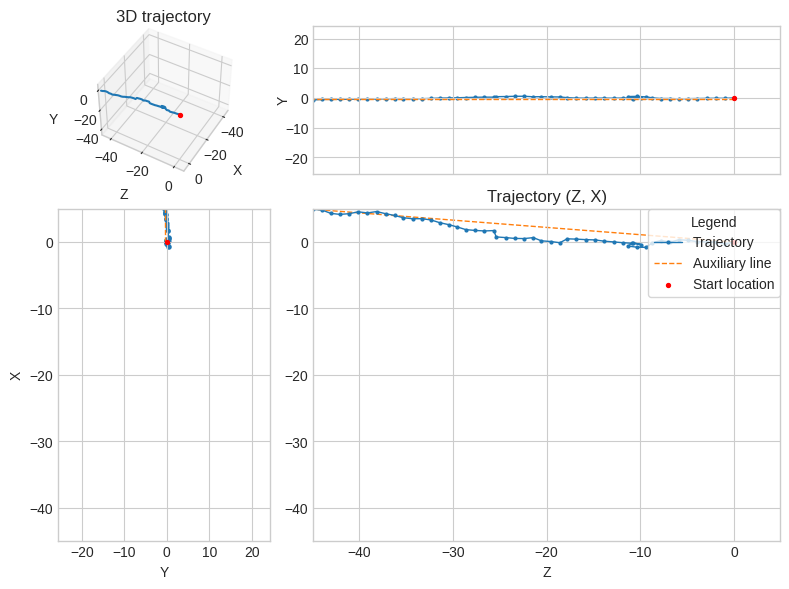

In [97]:
visualize_trajectory(trajectory)

In [98]:
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML

locX, locY, locZ = [], [], []

# Set up the figure
fig = plt.figure(figsize=(8, 6), dpi=100)
gspec = gridspec.GridSpec(3, 3)
ZY_plt = plt.subplot(gspec[0, 1:])
YX_plt = plt.subplot(gspec[1:, 0])
traj_main_plt = plt.subplot(gspec[1:, 1:])
D3_plt = plt.subplot(gspec[0, 0], projection='3d')

# Determine plot limits
max_value = np.max(trajectory)
min_value = np.min(trajectory)
maxY, minY = max_value, min_value

def animate(i):
    current_pos = trajectory[:, i]
    print(f"Frame {i}: {current_pos}")  # 프레임 번호와 현재 포지션 출력
    locX.append(current_pos[0])
    locY.append(current_pos[1])
    locZ.append(current_pos[2])

    traj_main_plt.clear()
    ZY_plt.clear()
    YX_plt.clear()
    D3_plt.clear()

    # Main trajectory plot (Z, X)
    traj_main_plt.set_title("Autonomous vehicle trajectory (Z, X)", y=1.06)
    traj_main_plt.plot(locZ, locX, ".-", label="Trajectory", zorder=1, linewidth=1, markersize=4)
    traj_main_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    traj_main_plt.set_xlim([min_value, max_value])
    traj_main_plt.set_ylim([min_value, max_value])
    traj_main_plt.set_xlabel("Z")
    traj_main_plt.legend(loc=1, title="Legend", borderaxespad=0., fontsize="medium", frameon=True)

    # ZY plot
    ZY_plt.plot(locZ, locY, ".-", linewidth=1, markersize=4, zorder=0)
    ZY_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    ZY_plt.set_xlim([min_value, max_value])
    ZY_plt.set_ylim([minY, maxY])
    ZY_plt.set_ylabel("Y")
    ZY_plt.axes.xaxis.set_ticklabels([])

    # YX plot
    YX_plt.plot(locY, locX, ".-", linewidth=1, markersize=4, zorder=0)
    YX_plt.scatter([0], [0], s=8, c="red", label="Start location", zorder=2)
    YX_plt.set_xlim([minY, maxY])
    YX_plt.set_ylim([min_value, max_value])
    YX_plt.set_xlabel("Y")
    YX_plt.set_ylabel("X")

    # 3D plot
    D3_plt.plot3D(locX, locZ, locY, zorder=0)
    D3_plt.scatter(0, 0, 0, s=8, c="red", zorder=1)
    D3_plt.set_xlim3d(min_value, max_value)
    D3_plt.set_ylim3d(min_value, max_value)
    D3_plt.set_zlim3d(min_value, max_value)
    D3_plt.set_xlabel("X", labelpad=0)
    D3_plt.set_ylabel("Z", labelpad=0)
    D3_plt.set_zlabel("Y", labelpad=-2)
    D3_plt.view_init(45, azim=30)

# Create animation
ani = animation.FuncAnimation(fig, animate, frames=trajectory.shape[1], interval=100, repeat=True)
HTML(ani.to_jshtml())
# plt.tight_layout()
# plt.show()

Output hidden; open in https://colab.research.google.com to view.

Congrats on finishing this assignment!